In [140]:
#!pip install python-sat

In [141]:
import matplotlib.pyplot as plt
from pysat.formula import CNF
from pysat.solvers import Solver
from sympy import symbols, Or, And, Not, simplify_logic
from itertools import combinations
import random
from copy import deepcopy
import time

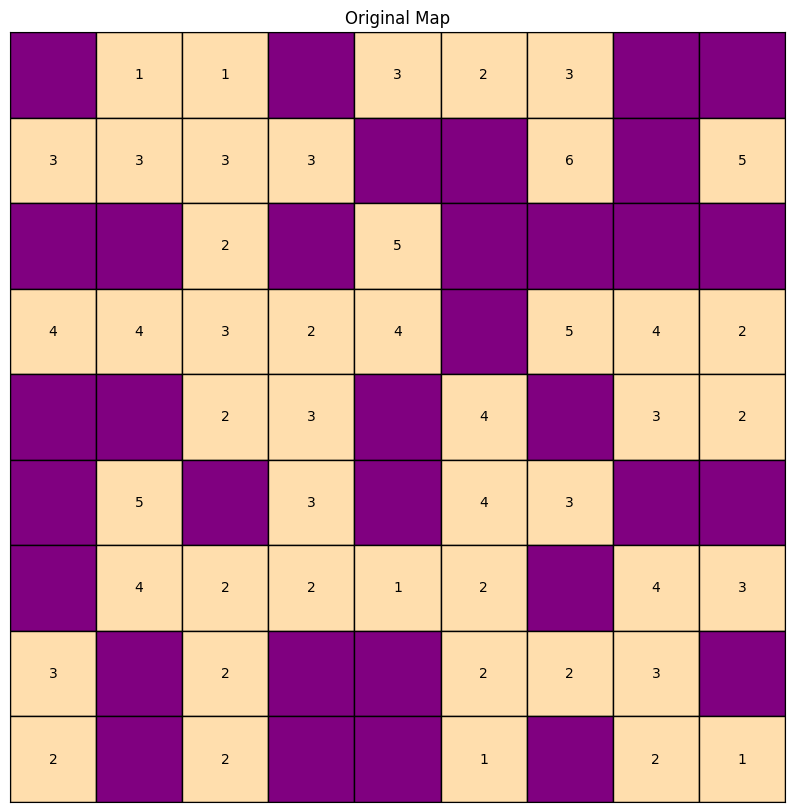

In [142]:
class Cell:
    def __init__(self, value, number, pos_row, pos_col):
        self.value = value      #True: Trap, False: Gem, Digit: number of traps
        self.number = number    #Cell order
        self.row = pos_row
        self.col = pos_col
        self.traps = 0
        self.trap_or_gem_list = []

    def countTrap(self, matrix):
        size = len(matrix)
        if (self.value != True) and (self.value != False):
            if (self.row - 1 < 0): top = self.row
            else: top = self.row - 1

            if (self.row + 1 >= size): bottom = self.row
            else: bottom = self.row + 1

            if (self.col - 1 < 0): left = self.col
            else: left = self.col - 1

            if (self.col + 1 >= size): right = self.col
            else: right = self.col + 1

            for i in range(top, bottom + 1):
                for j in range(left, right + 1):
                    if (matrix[i][j].value == True):
                        self.traps = self.traps + 1

    def getTrapOrGem(self, matrix):
        size = len(matrix)
        if (self.value != True) and (self.value != False):
            if (self.row - 1 < 0): top = self.row
            else: top = self.row - 1

            if (self.row + 1 >= size): bottom = self.row
            else: bottom = self.row + 1

            if (self.col - 1 < 0): left = self.col
            else: left = self.col - 1

            if (self.col + 1 >= size): right = self.col
            else: right = self.col + 1

            for i in range(top, bottom + 1):
                for j in range(left, right + 1):
                    if (matrix[i][j].value == True) or (matrix[i][j].value == False):
                        self.trap_or_gem_list.append(matrix[i][j].number)

class Map():
    def readFile(self, filename):
        with open(filename, 'r') as file:
            lines = file.readlines()
            number = 1
            row_index = 0
            col_index = 0
            for line in lines:
                row = line.strip().split(',')
                row_values = []
                for value in row:
                    if (value.strip() == '_'):
                        val = Cell(True, number, row_index, col_index)
                        row_values.append(val)
                        number += 1
                    else:
                        val = Cell(value.strip(), number, row_index, col_index)
                        row_values.append(val)
                        number += 1
                    col_index = col_index + 1

                row_index = row_index + 1
                col_index = 0
                self.map_array.append(row_values)

            self.size = len(self.map_array)

    def __init__(self, filename):
        self.size = 0
        self.map_array = []
        self.readFile(filename)
        for row in self.map_array:
            for cell in row:
                cell.getTrapOrGem(self.map_array)

    def printMap(self, title):
        # Create figure and axes
        fig, ax = plt.subplots()

        fig.set_size_inches(10, 10)

        # Draw cells
        for i in range(0, self.size):
                for j in range(0, self.size):
                        if (self.map_array[i][j].value == True):
                            color = "purple"
                            text = "T"
                        elif (self.map_array[i][j].value == False):
                            color = "gold"
                            text = "G"
                        else:
                            color = "navajowhite"
                            text = self.map_array[i][j].value
                        rect = plt.Rectangle((j, i), 1, 1, facecolor=color, edgecolor="black")
                        ax.add_patch(rect)
                        # Ghi giá trị vào ô vuông
                        ax.text(j + 0.5, i + 0.5, text, ha="center", va="center", fontsize=10)

        # Add title
        ax.set_title(title)

        # Reduce the numberic lines
        ax.set_xticks([])
        ax.set_yticks([])

        # Set the limit of numberic lines
        ax.set_xlim(0, self.size)
        ax.set_ylim(self.size, 0)

        # Show matrix
        plt.show()
    def printOriginalMap(self):
        # Create figure and axes
        fig, ax = plt.subplots()

        fig.set_size_inches(10, 10)

        # Draw cells
        for i in range(0, self.size):
                for j in range(0, self.size):
                        if (self.map_array[i][j].value == True):
                            color = "purple"
                            text = ""
                        else:
                            color = "navajowhite"
                            text = self.map_array[i][j].value
                        rect = plt.Rectangle((j, i), 1, 1, facecolor=color, edgecolor="black")
                        ax.add_patch(rect)
                        # Ghi giá trị vào ô vuông
                        ax.text(j + 0.5, i + 0.5, text, ha="center", va="center", fontsize=10)

        # Add title
        ax.set_title("Original Map")

        # Reduce the numberic lines
        ax.set_xticks([])
        ax.set_yticks([])

        # Set the limit of numberic lines
        ax.set_xlim(0, self.size)
        ax.set_ylim(self.size, 0)

        # Show matrix
        plt.show()

file_path = "Map/9x9/9x9.txt"
map = Map(file_path)
#map.readFile(file_path)
map.printOriginalMap()
# print(map.map_array[0][0].UnrevealedTiles)

In [143]:
# Generate CNF automatically
def distribute_traps(TrapOrGem, NumOfTrap):
    #This function is used to create a list of list of int
    #The input TrapOrGem is the list of all the cell number that can be trap or gem surrounding one number tile
    #NumOfTrap is the original value on that number tile
    #The total number of list is the combination (Tổ hợp chập) of NumOfTrap out of len(TrapOrGem)

    result = []

    # Generate all combinations of traps
    for combo in combinations(range(len(TrapOrGem)), NumOfTrap):
        distributed = []
        for i in range(len(TrapOrGem)):
            if i in combo:
                distributed.append(TrapOrGem[i])  # Add trap (positive value)
            else:
                distributed.append(-TrapOrGem[i])   # Add gem (negative value)
        result.append(distributed)

    return result

def simplify_clause(all_trap_or_gem):
    #The input all_trap_or_gem is all possibility of trap or gem surrounding one number tile represented by a list of list of int
    #Before simplification, between list has the relation of Or
    #between int within a list has the relation of And
    #After simplification, between list has the relation of And
    #between int within a list has the relation of Or, which is suitable input for pysat CNF using extend method

    if len(all_trap_or_gem) == 0:
        return all_trap_or_gem
    elif len(all_trap_or_gem) == 1:
        return [[x] for x in all_trap_or_gem[0]]    #Convert Or to And

    #Preparation
    variables = ''
    for item in all_trap_or_gem[0]:
        variables += str(item) if item > 0 else str(item * -1)
        variables += ' '

    variables = variables[0:-1]     #variables is like '1 2 3 4'

    var = symbols(variables)        #var is a tuple of variable name

    Or_list = []                    #Between list is Or relation
    for arr in all_trap_or_gem:
        And_list = []               #Between list element is And relation
        for i in range(len(arr)):
            if arr[i] > 0:
                And_list.append(var[i])     #Add trap
            else:
                And_list.append(Not(var[i]))    #Add gem
        Or_list.append(And(*And_list))

    #Simplify
    expr = Or(*Or_list)
    simplified_expr = simplify_logic(expr, form='cnf')

    #Convert simplified_expr to list of list of int
    clauses = simplified_expr.args
    list_ = []
    for clause in clauses:
        list_.append(list(clause.args))
    for arr in list_:
        for i in range(len(arr)):
            arr[i] = str(arr[i])
            if arr[i][0] == '~':
                arr[i] = '-' + arr[i][1:]
            arr[i] = int(arr[i])
    return list_

def generateCNF(map_array):
    cnf = CNF()

    rows = len(map_array)
    cols = len(map_array[0])

    for i in range(rows):
        for j in range(cols):
            if (map_array[i][j].value != False) and (map_array[i][j].value != True):
                #Number of positive int in trap_or_gem_list
                num_of_trap = int(map_array[i][j].value)      

                #At this step, relation between list element is an "AND" and between 2 list is "OR"
                all_trap_or_gem = distribute_traps(map_array[i][j].trap_or_gem_list, num_of_trap)

                #At this step, the logic expression above is simplified, 
                #relation between list element is "OR" and between 2 list is "AND"
                clauses = simplify_clause(all_trap_or_gem)                      
                cnf.extend(clauses)

    return cnf


#Generate CNF for the map 9x9
cnf = generateCNF(map.map_array)                        #In pysat format
cnf_list = [list(clause) for clause in cnf.clauses]     #In list of list of int format

In [144]:
# Use pysat to solve CNFs
def solveCNF(cnf):
    with Solver(bootstrap_with=cnf) as solver:
        # 1.1 call the solver for this formula:
        print('formula is', f'{"s" if solver.solve() else "uns"}atisfiable')

        # 1.2 the formula is satisfiable and so has a model:
        print('and the model is:', solver.get_model())

        # 2.1 apply the MiniSat-like assumption interface:
        print('formula is',
            f'{"s" if solver.solve(assumptions=[1, 2]) else "uns"}atisfiable',
            'assuming x1 and x2')

        # 2.2 the formula is unsatisfiable,
        # i.e. an unsatisfiable core can be extracted:
        print('and the unsatisfiable core is:', solver.get_core())


#Solve CNF for the map 9x9
solveCNF(cnf)

formula is satisfiable
and the model is: [1, -2, -3, 4, -5, -6, -7, 8, 9, -10, -11, -12, -13, 14, 15, -16, 17, -18, 19, 20, -21, 22, -23, 24, 25, 26, 27, -28, -29, -30, -31, -32, 33, -34, -35, -36, 37, 38, -39, -40, 41, -42, 43, -44, -45, 46, -47, 48, -49, 50, -51, -52, 53, 54, 55, -56, -57, -58, -59, -60, 61, -62, -63, -64, 65, -66, -67, -68, -69, -70, -71, 72, -73, 74, -75, -76, -77, -78, 79]
formula is satisfiable assuming x1 and x2
and the unsatisfiable core is: None


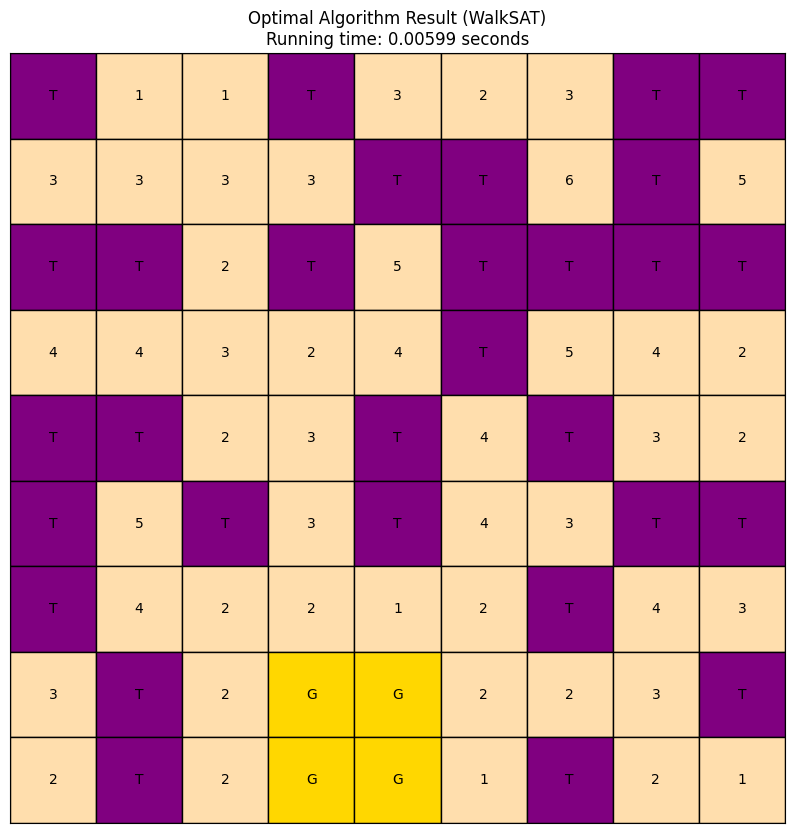

In [145]:
# Use the optimal algorithm to solve CNFs (WalkSAT algorithm)
def WalkSAT(clauses, p=0.5, max_flips=10000):
    # Randomly assign True or False to each variable
    #assignment = {i: True for i in range(1, map.size * map.size + 1)}
    assignment = {var: random.choice([True, False]) for var in variables(clauses)}
    
    for _ in range(max_flips):
        unsatisfied = [c for c in clauses if not is_true(c, assignment)]
        if not unsatisfied:  # If there are no unsatisfied clauses, return the assignment
            return assignment
        clause = random.choice(unsatisfied)
        if random.random() < p:
            var = random.choice([abs(x) for x in clause])
        else:
            # Flip the variable in the clause that results in the most satisfied clauses
            var = max((abs(x) for x in clause), key=lambda v: num_satisfied(clauses, assignment, v))
        assignment[var] = not assignment[var]

    # If no satisfying assignment is found within the maximum number of flips, return None
    return None

def variables(clauses):
    return set(abs(x) for clause in clauses for x in clause)

def is_true(clause, assignment):
    return any((x > 0) == assignment.get(abs(x), False) for x in clause)

def num_satisfied(clauses, assignment, var):
    # Returns the number of satisfied clauses when the value of var is flipped
    assignment = assignment.copy()
    assignment[var] = not assignment[var]
    return sum(is_true(c, assignment) for c in clauses)

# Example usage:
def implementWalkSAT(myMap, myCNF):
    if WalkSAT(myCNF) != None:
        result_map = deepcopy(myMap)
        start_time = time.time()
        solution = WalkSAT(myCNF)
        end_time = time.time()
        #print("Solution:", solution)
        for i in range(0, result_map.size):
            for j in range(0, myMap.size):
                if (type(result_map.map_array[i][j].value) == bool): 
                    if (solution[i * myMap.size + j + 1] == True):
                        result_map.map_array[i][j].value = True
                    else:
                        result_map.map_array[i][j].value = False
                else: continue
        running_time = end_time - start_time
        title = f'Optimal Algorithm Result (WalkSAT)\nRunning time: {running_time:.5f} seconds'
        result_map.printMap(title)
    else:
        print("No solution found.")

implementWalkSAT(map, cnf)

In [146]:
def convert_numeric_strings_to_integers(map):
    for row in map.map_array:
        for cell in row:
            if isinstance(cell.value, str) and cell.value.isdigit():
                cell.value = int(cell.value)
    
def convert_true_to_none(map):
    for row in map.map_array:
        for cell in row:
            if type(cell.value) is bool:
                cell.value = None

def solve_map_with_brute_force(map):
    copied_map = deepcopy(map)
    size = copied_map.size

    start_time = time.time()
    
    def is_configuration_valid(configuration):
        # Check if the configuration satisfies all constraints
        for i in range(size):
            for j in range(size):
                cell = copied_map.map_array[i][j]
                if cell.value is not None:
                    count_traps = sum(1 for ni, nj in get_neighbors(i, j) if configuration[ni][nj] == 'T')
                    if cell.value != count_traps:
                        return False
        return True
    
    def generate_possible_configurations(configuration, index):
        if index == size * size:
            return is_configuration_valid(configuration)
        
        i, j = divmod(index, size)
        
        if copied_map.map_array[i][j].value is None:
            configuration[i][j] = 'T'
            if generate_possible_configurations(configuration, index + 1):
                return True
            configuration[i][j] = 'G'
            if generate_possible_configurations(configuration, index + 1):
                return True
            return False
        else:
            return generate_possible_configurations(configuration, index + 1)
    
    def get_neighbors(i, j):
        for ni in range(max(0, i-1), min(size, i+2)):
            for nj in range(max(0, j-1), min(size, j+2)):
                if ni != i or nj != j:
                    yield ni, nj
    
    initial_configuration = [[copied_map.map_array[i][j].value for i in range(size)] for j in range(size)]
    
    result = generate_possible_configurations(initial_configuration, 0)
    
    end_time = time.time()  
    
    if result:
        for i in range(size):
            for j in range(size):
                if initial_configuration[i][j] == "T":
                    copied_map.map_array[i][j].value = True
                elif initial_configuration[i][j] == "G":
                    copied_map.map_array[i][j].value = False
                else:
                    copied_map.map_array[i][j].value = str(copied_map.map_array[i][j].value)
        running_time = end_time - start_time
        title = f'Brute Force Algorithm Result\nRunning time: {running_time:.5f} seconds'        
        copied_map.printMap(title)
    else:
        print("No solution found.")

In [147]:
def solve_map_with_backtracking(map):
    copied_map = deepcopy(map)
    size = copied_map.size
    
    start_time = time.time()  # Record the start time
    
    def is_configuration_valid(configuration):
        # Check if the configuration satisfies all constraints
        for i in range(size):
            for j in range(size):
                cell = copied_map.map_array[i][j]
                if cell.value is not None:
                    count_traps = sum(1 for ni, nj in get_neighbors(i, j) if configuration[ni][nj] == 'T')
                    if cell.value != count_traps:
                        return False
        return True
    
    def generate_configurations(configuration, index):
        if index == size * size:
            return is_configuration_valid(configuration)
        
        i, j = divmod(index, size)
        
        if copied_map.map_array[i][j].value is None:
            for value in ['T', 'G']:
                configuration[i][j] = value
                if generate_configurations(configuration, index + 1):
                    return True
            return False
        else:
            return generate_configurations(configuration, index + 1)
    
    def get_neighbors(i, j):
        for ni in range(max(0, i-1), min(size, i+2)):
            for nj in range(max(0, j-1), min(size, j+2)):
                if ni != i or nj != j:
                    yield ni, nj
    
    initial_configuration = [[copied_map.map_array[i][j].value for i in range(size)] for j in range(size)]
    
    # Generate configurations recursively
    result = generate_configurations(initial_configuration, 0)
    
    end_time = time.time()  # Record the end time
    
    if result:
        for i in range(size):
            for j in range(size):
                if initial_configuration[i][j] == 'T':
                    copied_map.map_array[i][j].value = True
                elif initial_configuration[i][j] == 'G':
                    copied_map.map_array[i][j].value = False
                else:
                    copied_map.map_array[i][j].value = str(copied_map.map_array[i][j].value)
        
        running_time = end_time - start_time
        title = f'Backtracking Algorithm Result\nRunning time: {running_time:.5f} seconds'
        copied_map.printMap(title)
    else:
        print("No solution found.")

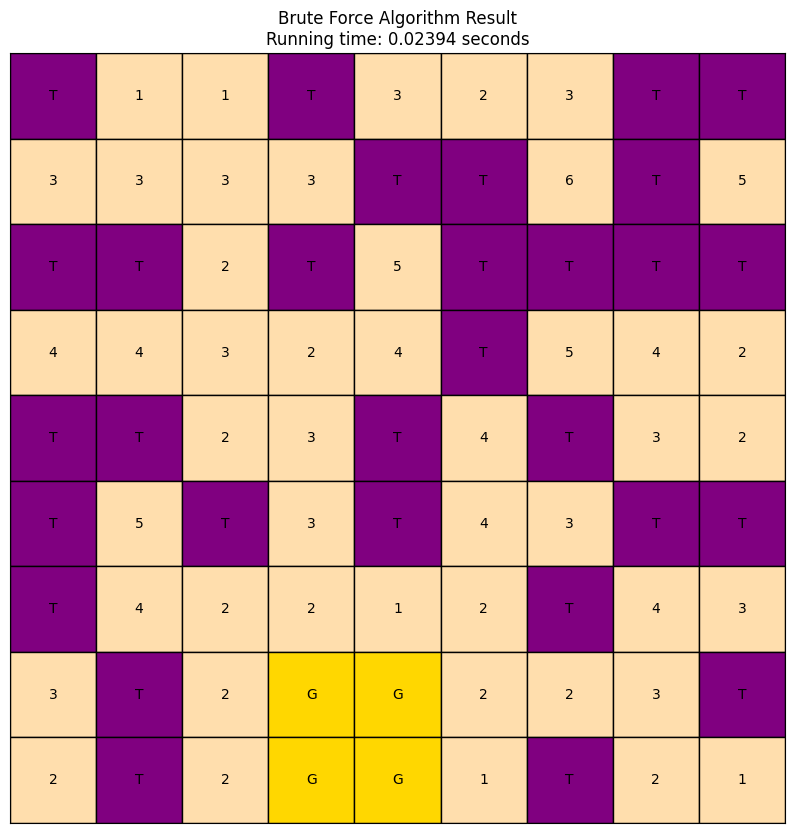

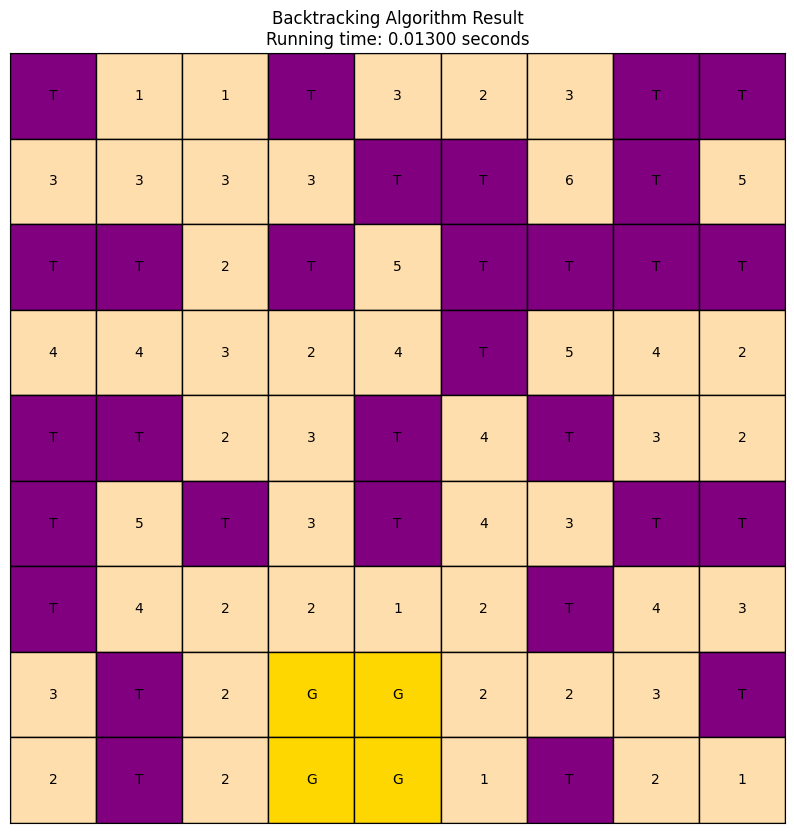

In [148]:
# Main (9x9 Map)

convert_numeric_strings_to_integers(map)
convert_true_to_none(map)

solve_map_with_brute_force(map)
solve_map_with_backtracking(map)

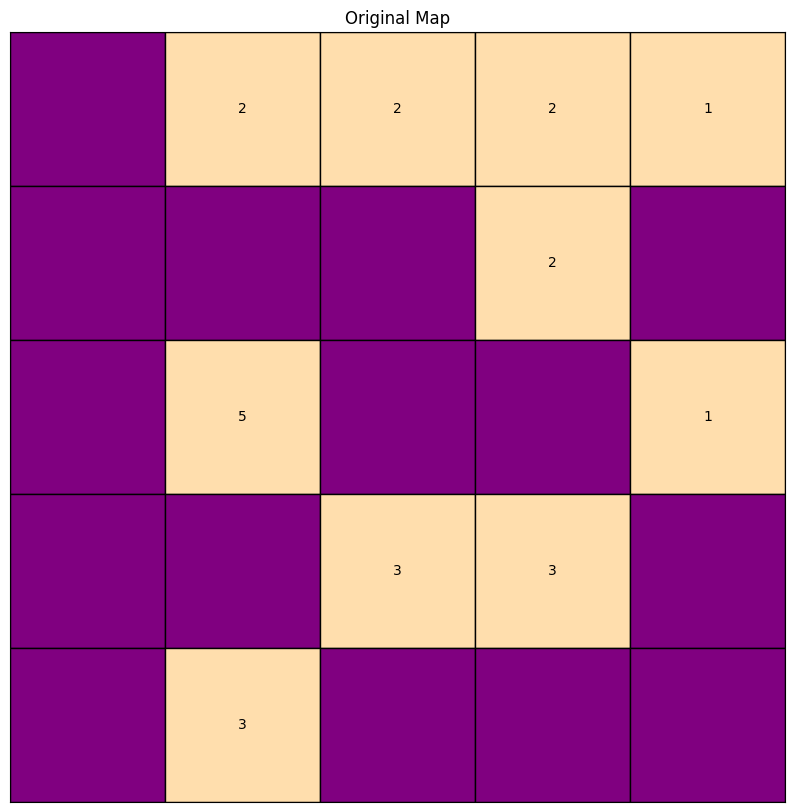

formula is satisfiable
and the model is: [-1, -2, -3, -4, -5, -6, 7, 8, -9, 10, 11, -12, -13, -14, -15, 16, 17, -18, -19, -20, -21, -22, 23, 24, 25]
formula is unsatisfiable assuming x1 and x2
and the unsatisfiable core is: [1]


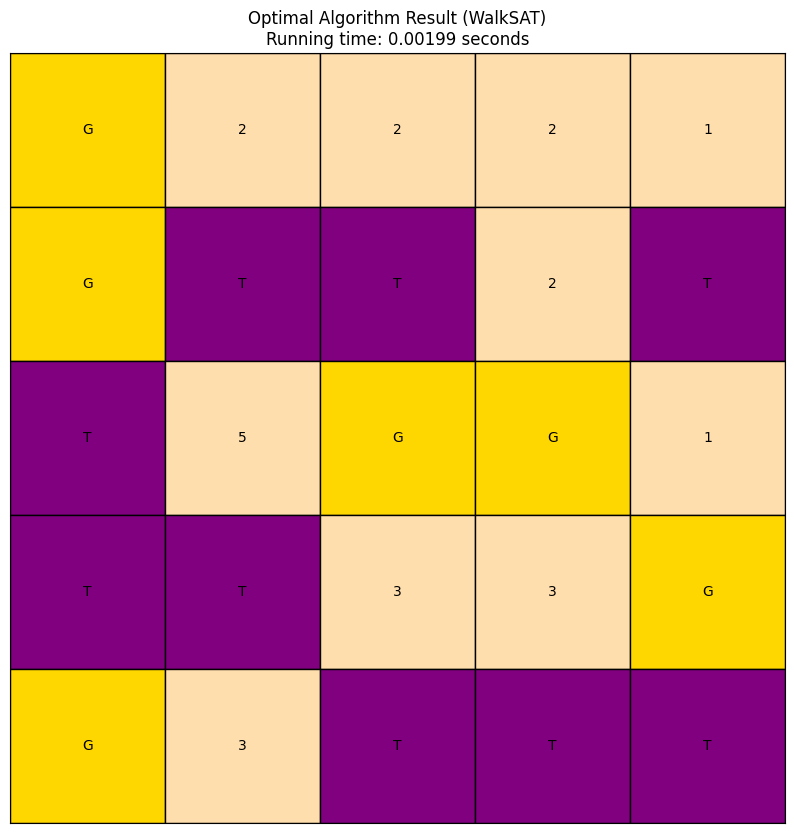

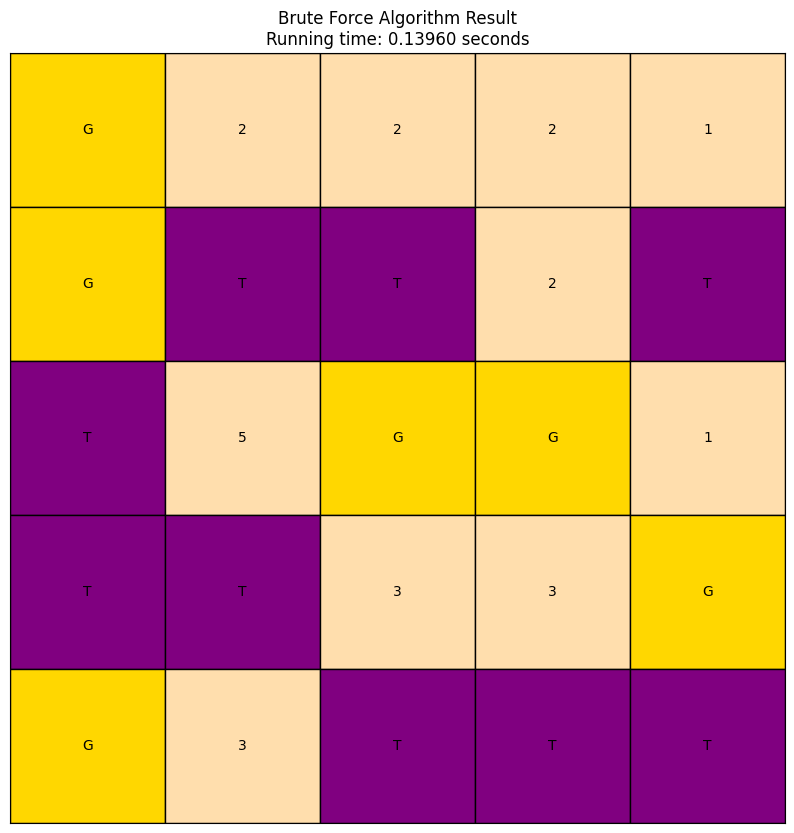

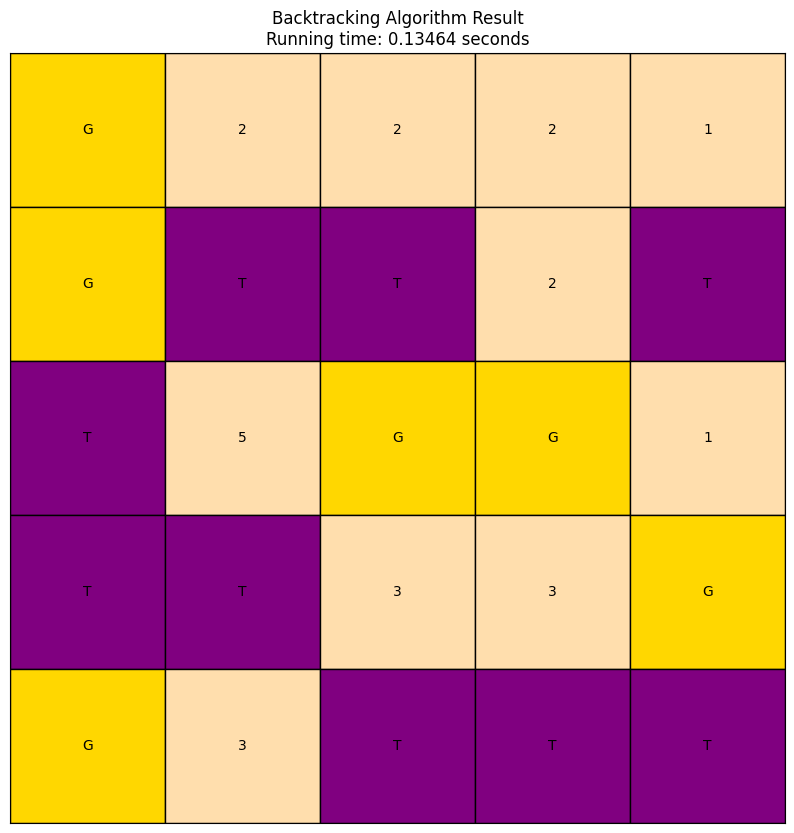

In [149]:
# 5x5 Map
file_path2 = "Map/5x5/5x5.txt"
map2 = Map(file_path2)
map2.printOriginalMap()

#Generate CNF for the map 5x5
cnf2 = generateCNF(map2.map_array)                        #In pysat format
cnf_list2 = [list(clause) for clause in cnf2.clauses]     #In list of list of int format

# Use pysat to solve CNFs
solveCNF(cnf2)

#Optimal algorithm measurement
implementWalkSAT(map2, cnf2)

#Brute force & Backtracking algorithm measurement
convert_numeric_strings_to_integers(map2)
convert_true_to_none(map2)

solve_map_with_brute_force(map2)
solve_map_with_backtracking(map2)


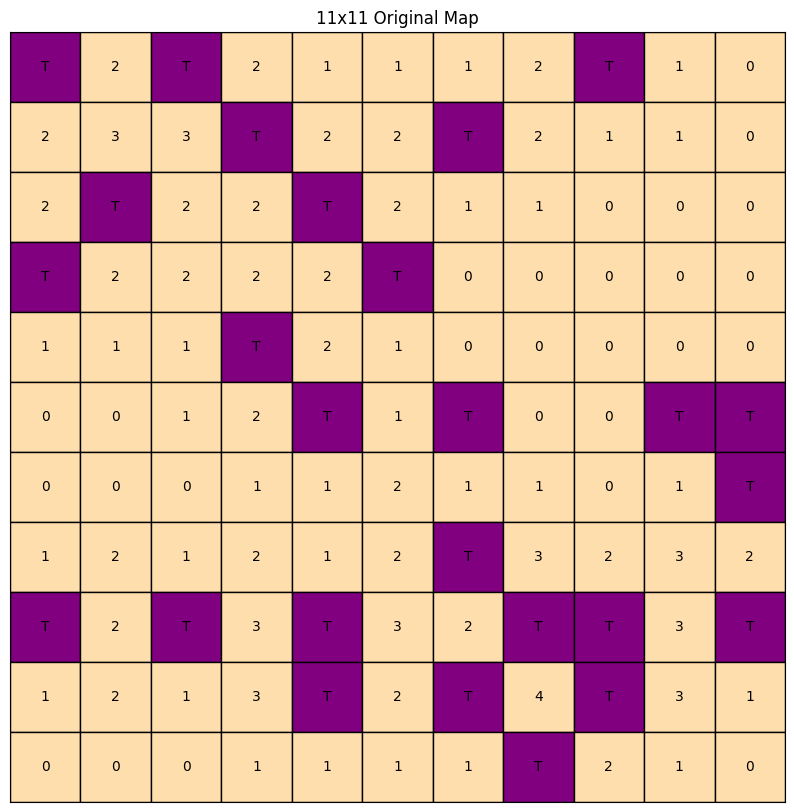

formula is satisfiable
and the model is: [1, -2, 3, -4, -5, -6, -7, -8, 9, -10, -11, -12, -13, -14, 15, -16, -17, 18, -19, -20, -21, -22, -23, 24, -25, -26, 27, -28, -29, -30, -31, -32, -33, 34, -35, -36, -37, -38, -39, -40, -41, -42, -43, -44, -45, -46, -47, 48, -49, -50, -51, -52, -53, -54, -55, -56, -57, -58, -59, 60, -61, -62, -63, -64, -65, -66, -67, -68, -69, -70, -71, -72, -73, -74, -75, -76, 77, -78, -79, -80, -81, -82, -83, 84, -85, -86, -87, -88, 89, -90, 91, -92, 93, -94, -95, 96, 97, -98, 99, -100, -101, -102, -103, 104, -105, -106, -107, 108, -109, -110, -111, -112, -113, -114, -115, -116, -117, 118]
formula is satisfiable assuming x1 and x2
and the unsatisfiable core is: None


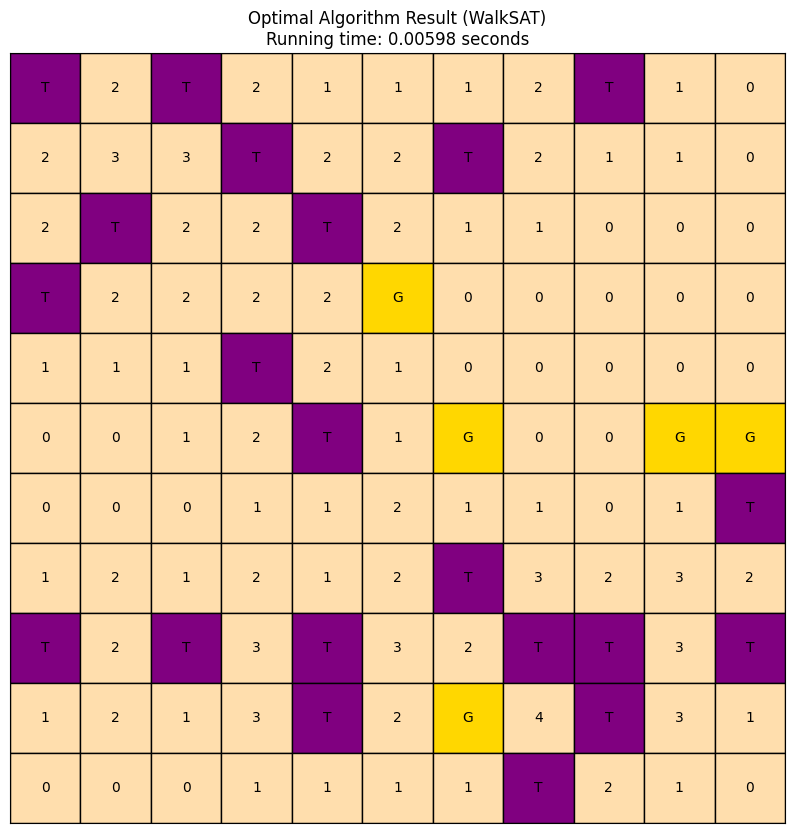

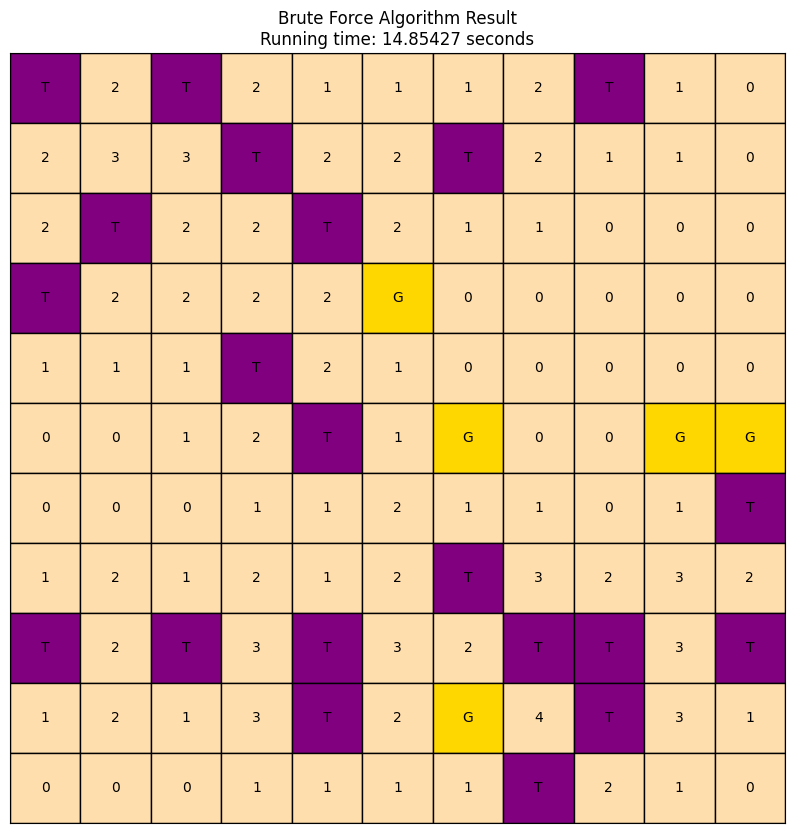

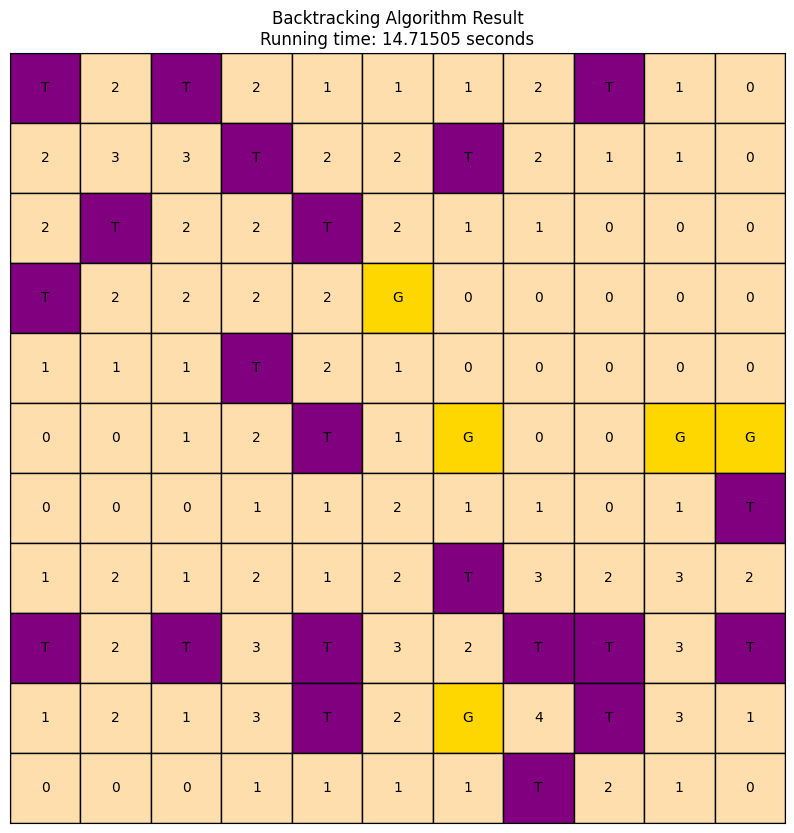

In [151]:
# 11x11 Map
file_path3 = "Map/11x11/11x11.txt"
map3 = Map(file_path3)
map3.printMap("11x11 Original Map")

#Generate CNF for the map 11x11
cnf3 = generateCNF(map3.map_array)                        #In pysat format
cnf_list3 = [list(clause) for clause in cnf3.clauses]     #In list of list of int format

# Use pysat to solve CNFs
solveCNF(cnf3)

#Optimal algorithm measurement
implementWalkSAT(map3, cnf3)

#Brute force & Backtracking algorithm measurement
convert_numeric_strings_to_integers(map3)
convert_true_to_none(map3)

solve_map_with_brute_force(map3)
solve_map_with_backtracking(map3)


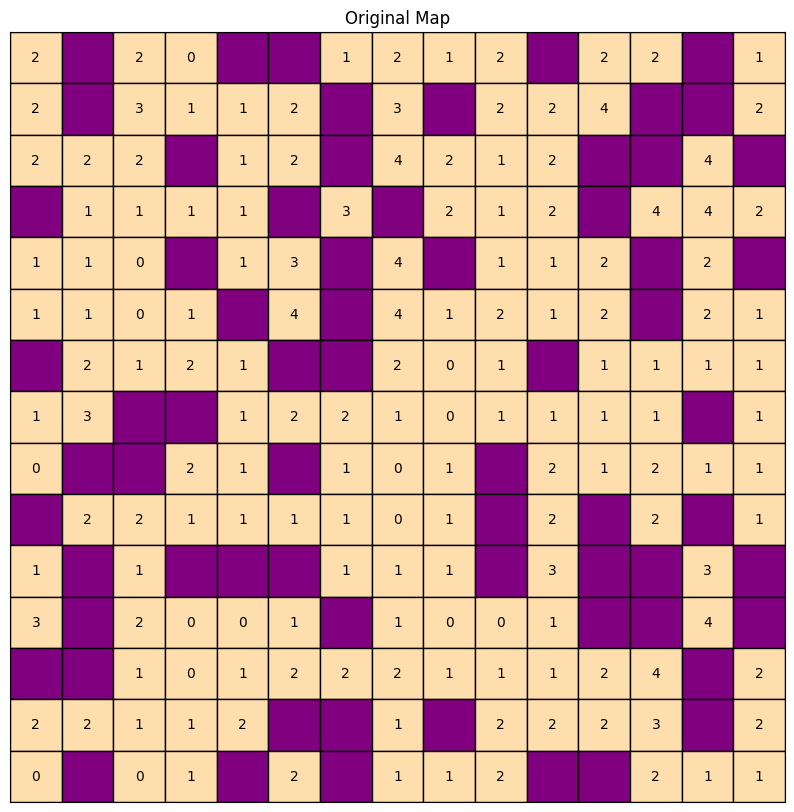

formula is satisfiable
and the model is: [-1, 2, -3, -4, -5, -6, -7, -8, -9, -10, 11, -12, -13, -14, -15, -16, 17, -18, -19, -20, -21, 22, -23, 24, -25, -26, -27, 28, 29, -30, -31, -32, -33, 34, -35, -36, 37, -38, -39, -40, -41, 42, 43, -44, 45, 46, -47, -48, -49, -50, -51, -52, 53, -54, -55, -56, 57, -58, -59, -60, -61, -62, -63, -64, -65, -66, 67, -68, 69, -70, -71, -72, 73, -74, 75, -76, -77, -78, -79, 80, -81, 82, -83, -84, -85, -86, -87, -88, -89, -90, 91, -92, -93, -94, -95, -96, 97, -98, -99, -100, 101, -102, -103, -104, -105, -106, -107, 108, -109, -110, -111, -112, -113, -114, -115, -116, -117, -118, 119, -120, -121, -122, 123, -124, -125, 126, -127, -128, -129, -130, -131, -132, -133, -134, -135, -136, -137, -138, -139, -140, -141, -142, -143, -144, 145, -146, 147, -148, -149, -150, -151, 152, -153, -154, -155, -156, -157, -158, -159, -160, -161, -162, 163, -164, 165, -166, -167, -168, -169, -170, -171, 172, -173, -174, -175, -176, 177, 178, -179, -180, 181, 182, -183, -184, 

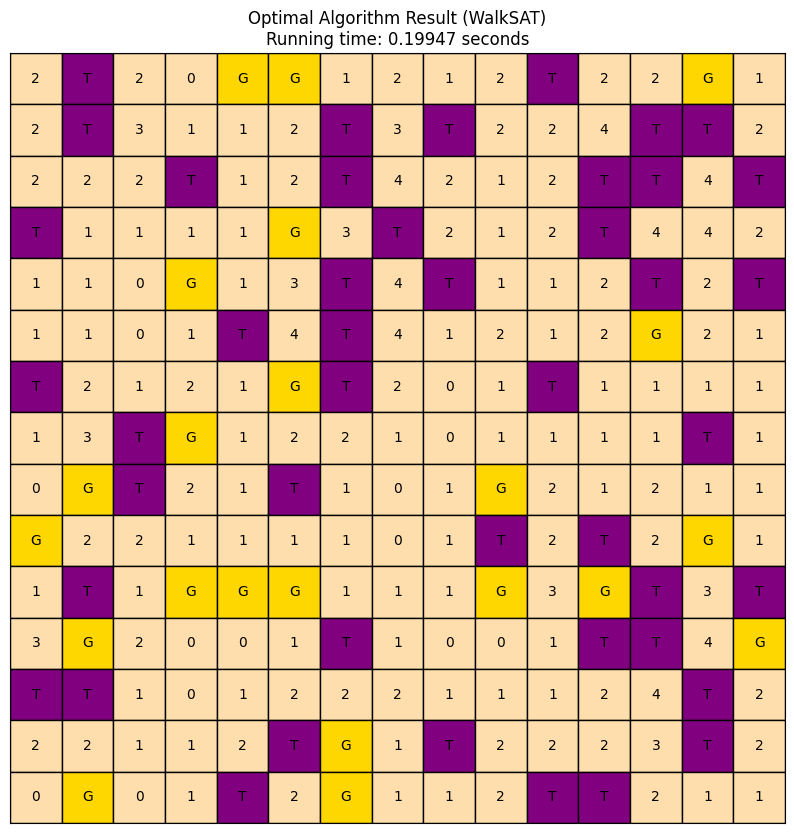

KeyboardInterrupt: 

In [156]:
# 15x15 Map
file_path4 = "Map/15x15/temp15x15.txt"
map4 = Map(file_path4)
map4.printOriginalMap()

#Generate CNF for the map 15x15
cnf4 = generateCNF(map4.map_array)                        #In pysat format
cnf_list4 = [list(clause) for clause in cnf4.clauses]     #In list of list of int format

# Use pysat to solve CNFs
solveCNF(cnf4)

#Optimal algorithm measurement
implementWalkSAT(map4, cnf4)

#Brute force & Backtracking algorithm measurement
convert_numeric_strings_to_integers(map4)
convert_true_to_none(map4)

solve_map_with_brute_force(map4)
solve_map_with_backtracking(map4)


In [ ]:
# 20x20 Map
file_path5 = "Map/20x20/20x20.txt"
map5 = Map(file_path5)
map5.printOriginalMap()

#Generate CNF for the map 20x20
cnf5 = generateCNF(map5.map_array)                        #In pysat format
cnf_list5 = [list(clause) for clause in cnf5.clauses]     #In list of list of int format

# Use pysat to solve CNFs
solveCNF(cnf5)

#Optimal algorithm measurement
implementWalkSAT(map5, cnf5)

#Brute force & Backtracking algorithm measurement
convert_numeric_strings_to_integers(map5)
convert_true_to_none(map5)
